In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pandas_profiling as pf
import warnings
warnings.filterwarnings('ignore')

In [180]:
df=pd.read_csv('OnlineNewsPopularity.csv')

In [181]:
#Removing spaces in column names
df.columns=[i.strip() for i in df.columns]

In [182]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Outlier Treatment

In [183]:
df_new=df.drop(columns=['url','timedelta'])

In [184]:
skew=[]
feature=[]
for i in df_new.columns:
    if (len(df[i].value_counts())>8) & (i!='shares'):
        feature.append(i)
        skew.append(df[i].skew()) 

In [185]:
df_skew=pd.DataFrame({'features':feature,'skewness':skew})

### Applying boxcox transformation to treat skewness

In [186]:
from scipy.stats import boxcox

In [187]:
for i in df_skew.features:
    if (min(df_new[i])<=0):
        df_new[i]=df_new[i]+np.abs(min(df_new[i]))+1

### Before boxcox transformation

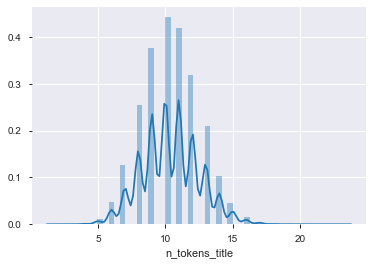

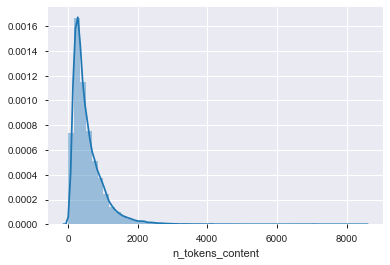

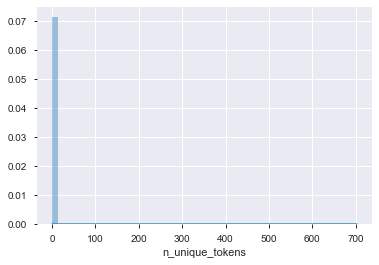

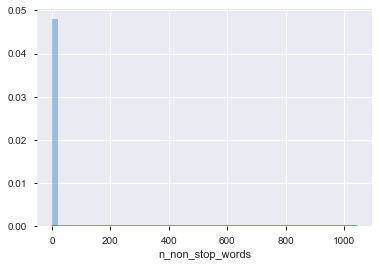

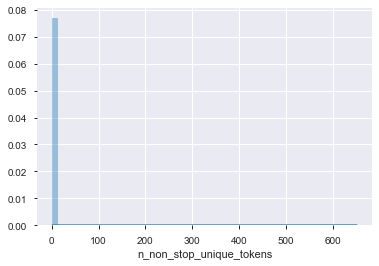

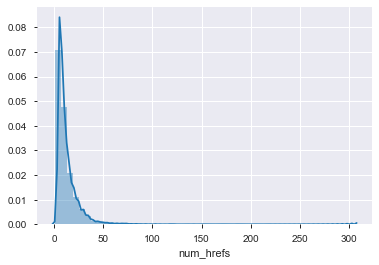

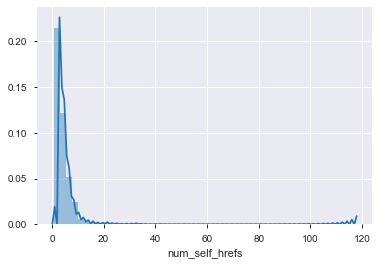

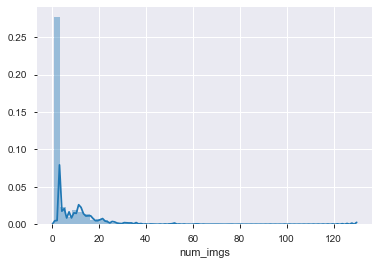

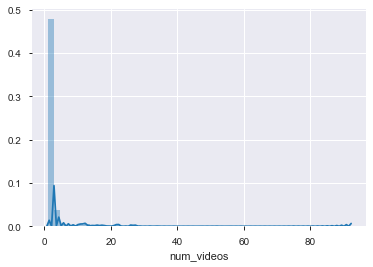

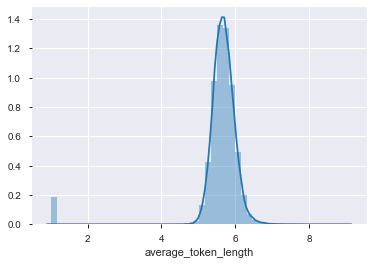

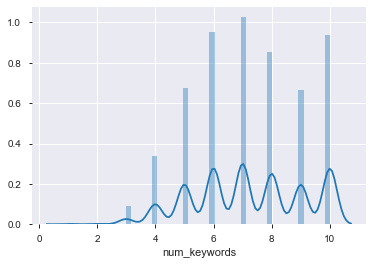

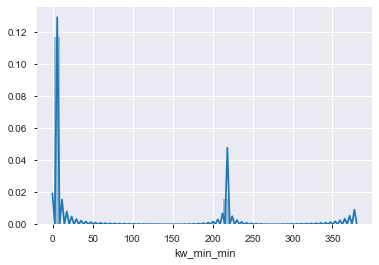

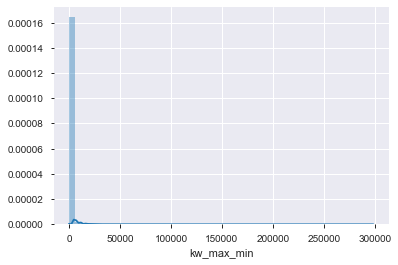

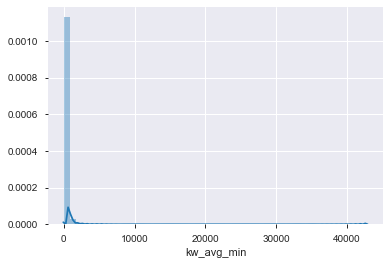

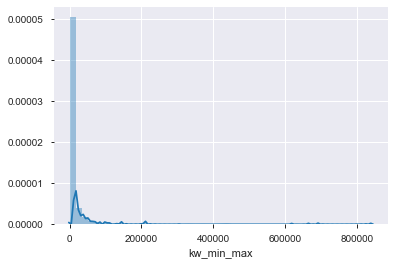

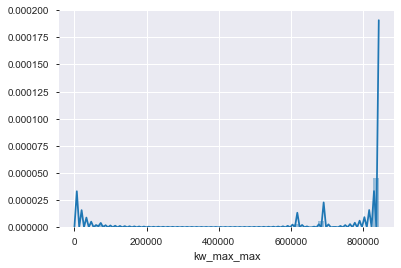

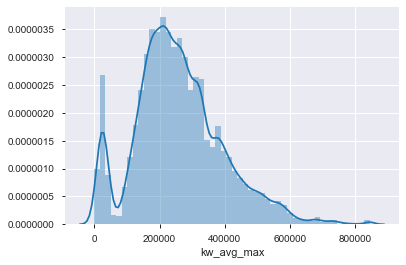

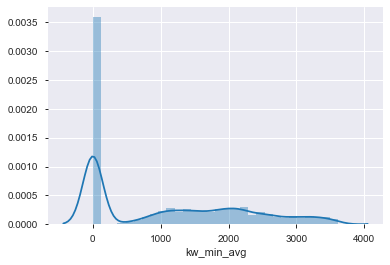

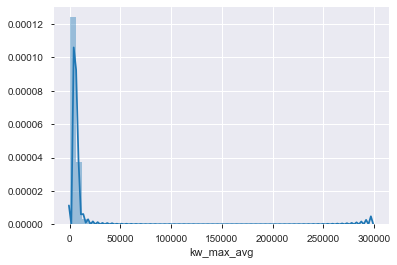

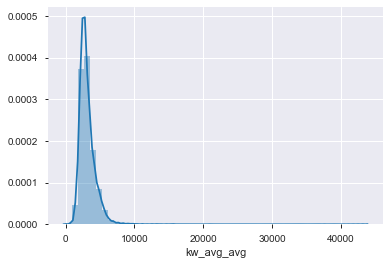

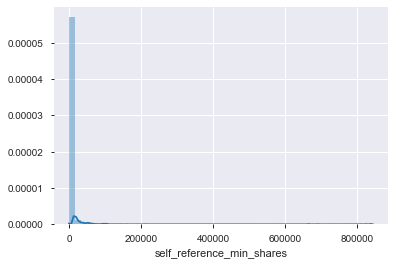

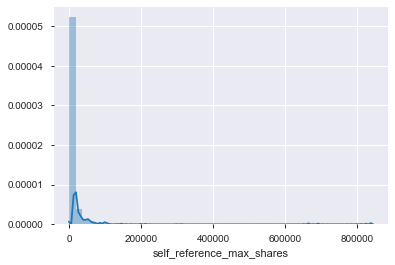

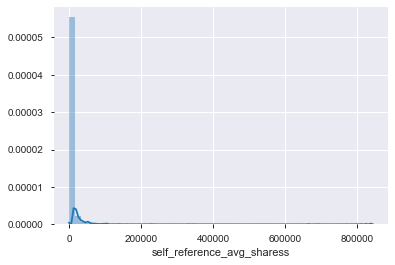

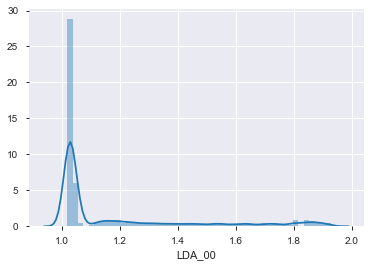

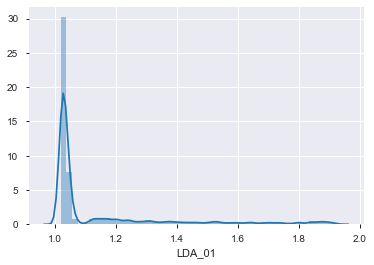

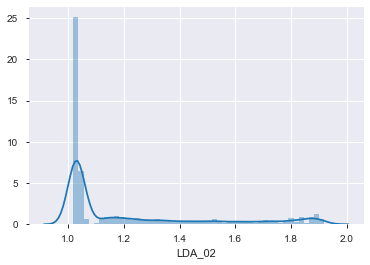

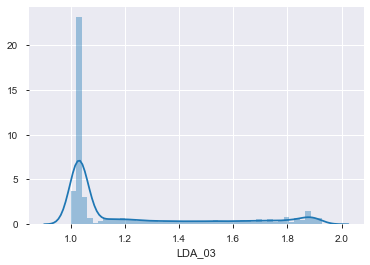

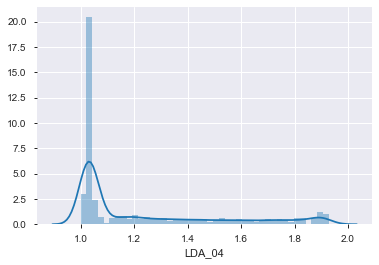

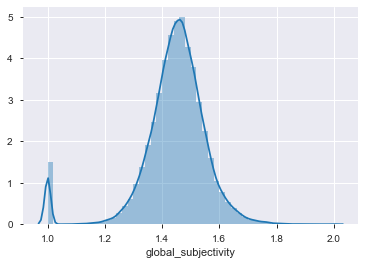

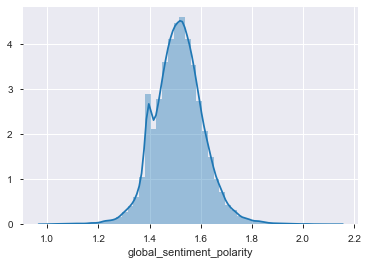

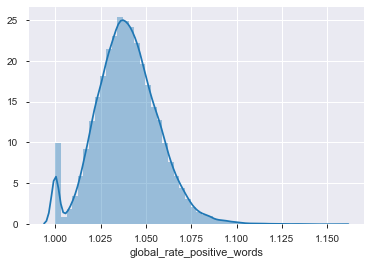

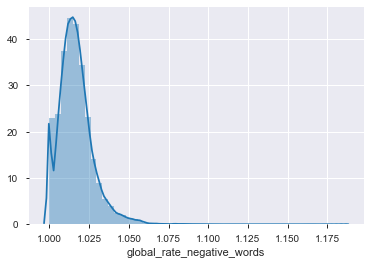

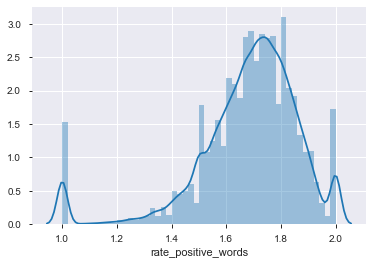

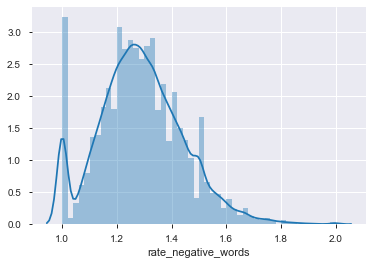

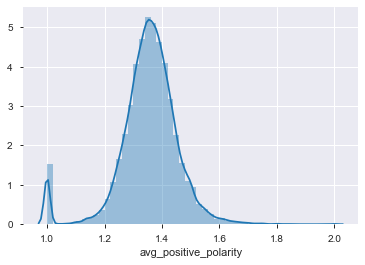

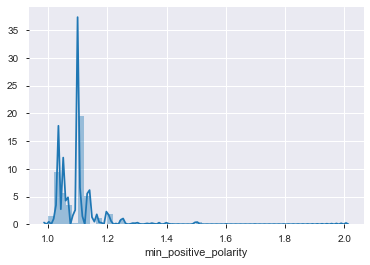

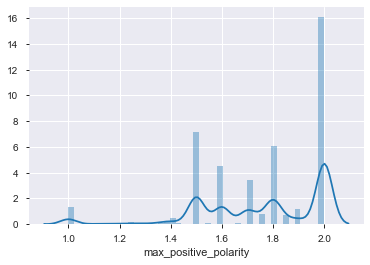

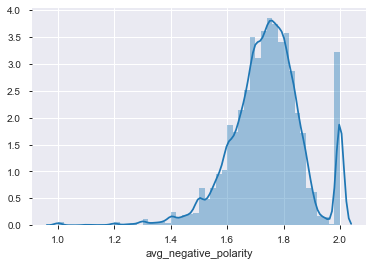

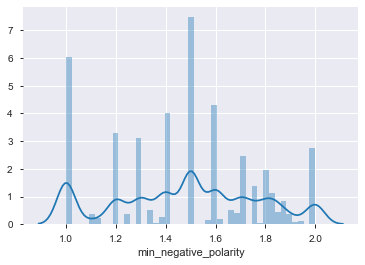

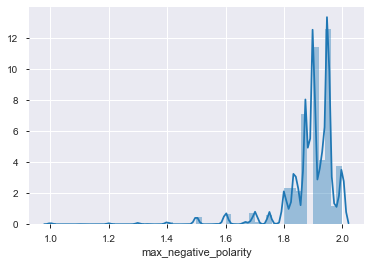

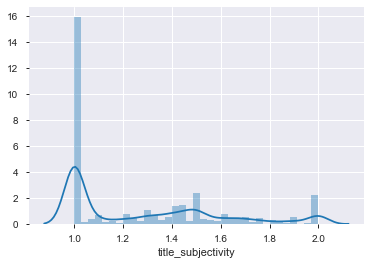

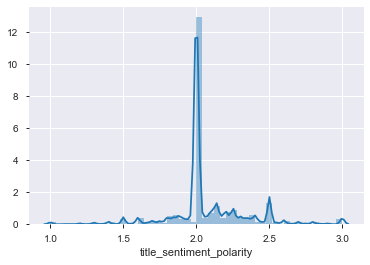

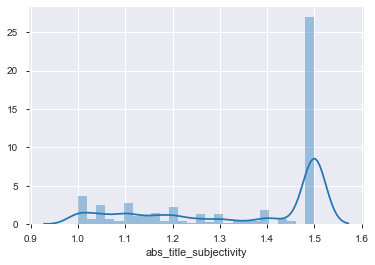

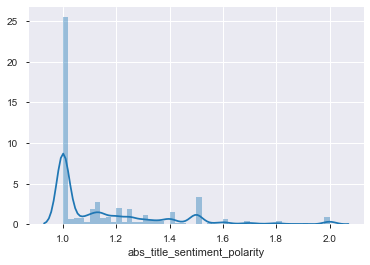

In [10]:
for i in df_skew.features:
    sns.distplot(df_new[i])
    plt.show()

In [188]:
for i in df_skew.features:
    df_new[i]=boxcox(df_new[i])[0]

### After boxcox

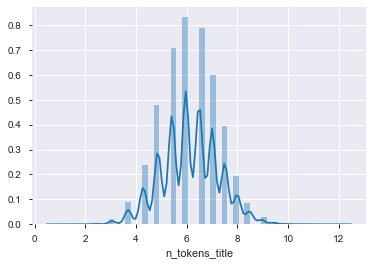

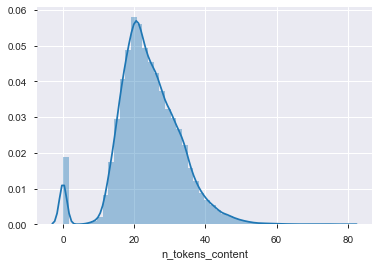

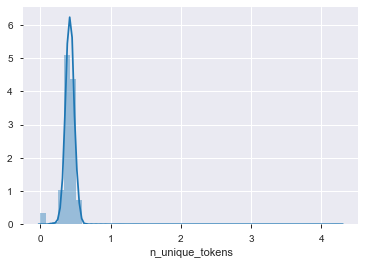

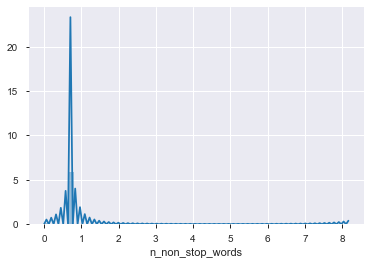

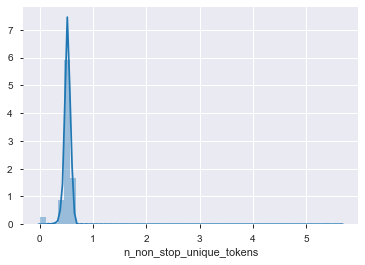

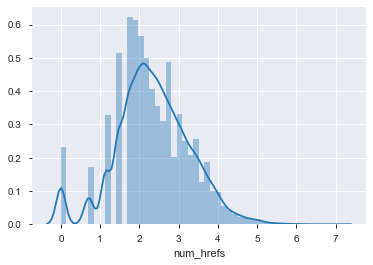

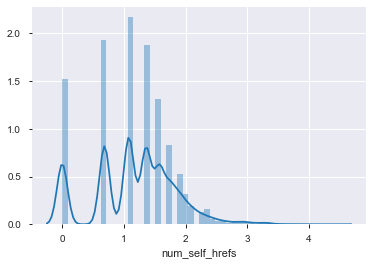

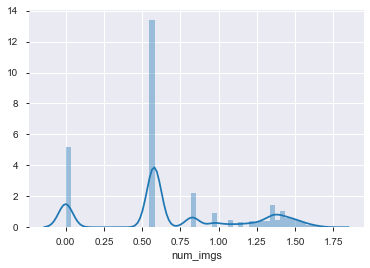

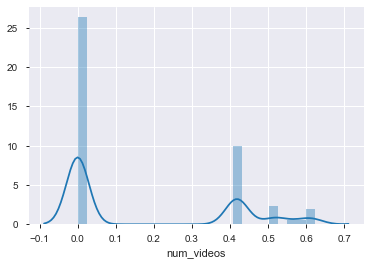

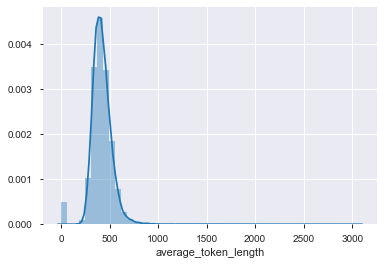

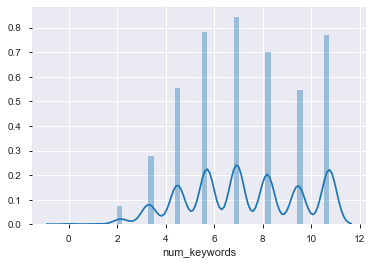

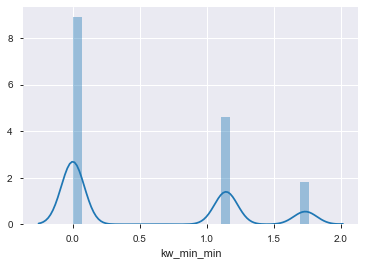

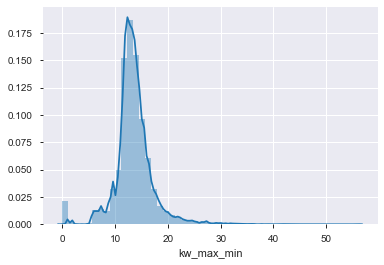

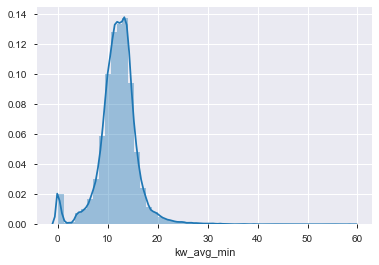

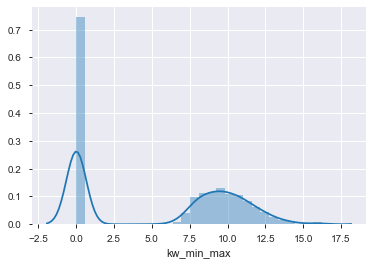

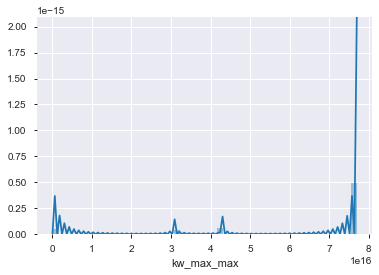

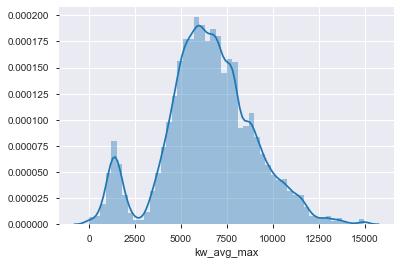

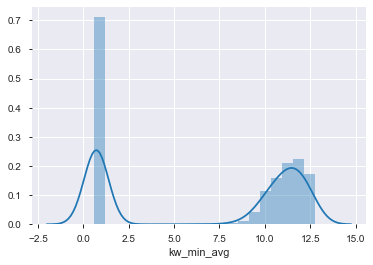

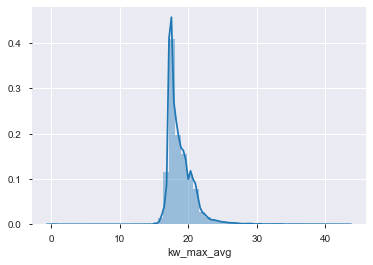

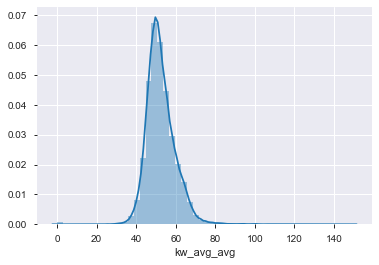

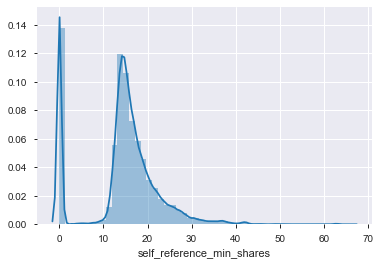

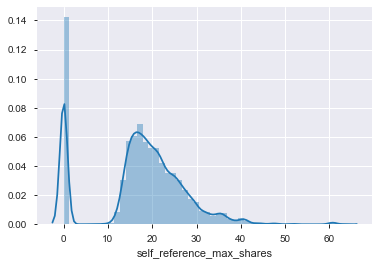

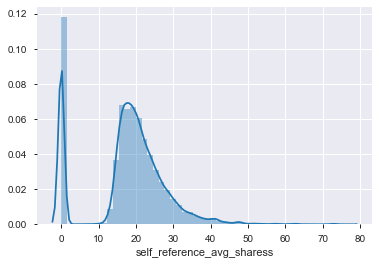

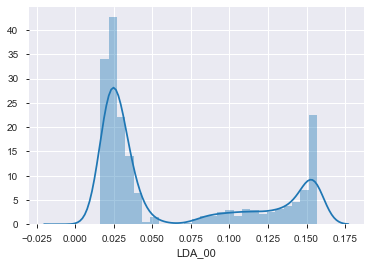

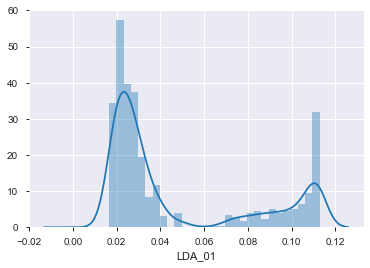

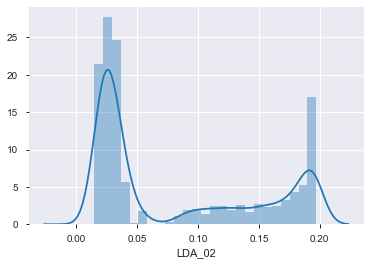

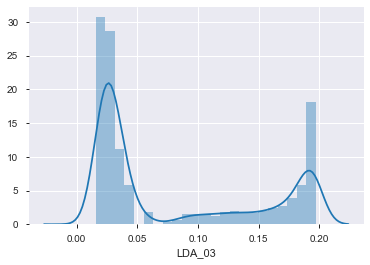

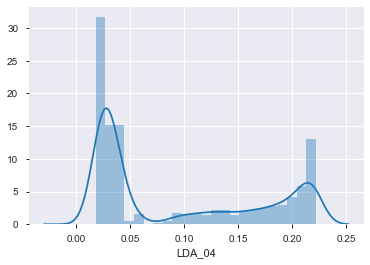

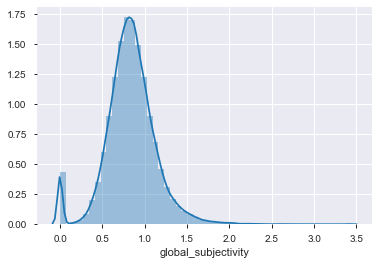

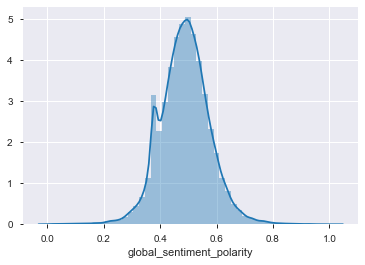

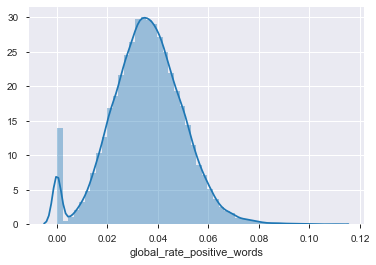

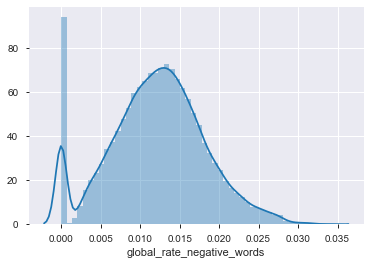

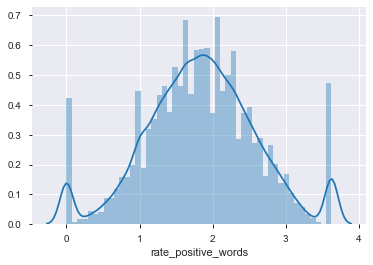

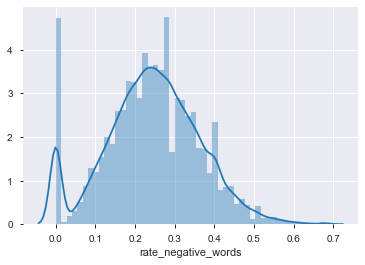

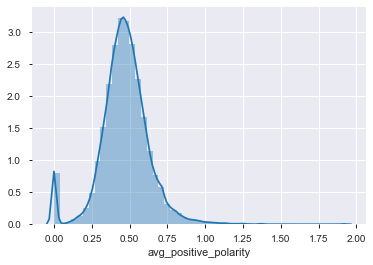

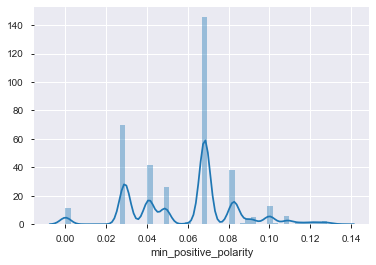

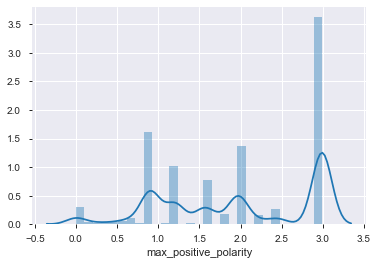

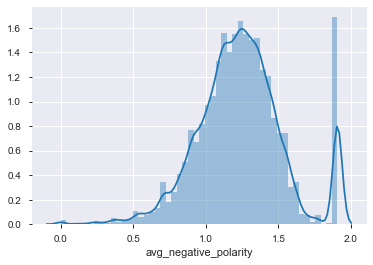

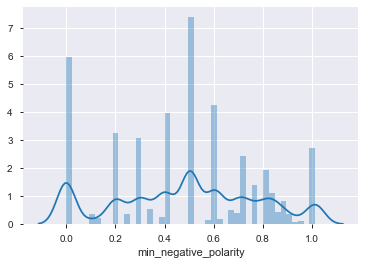

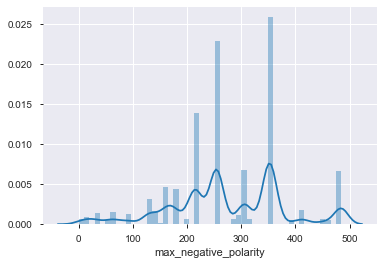

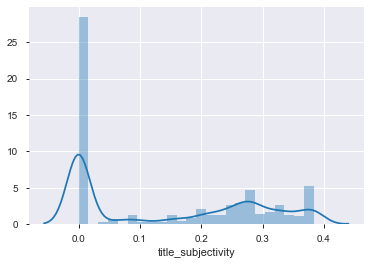

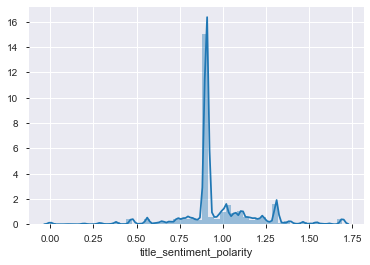

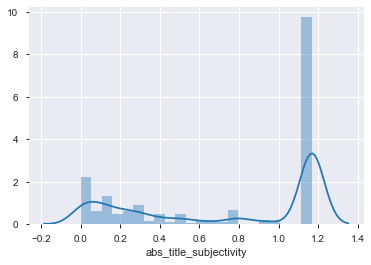

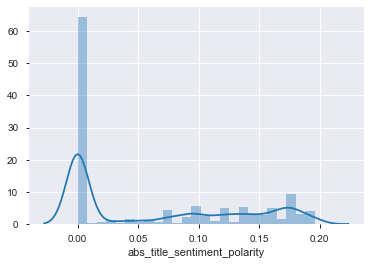

In [12]:
for i in df_skew.features:
    sns.distplot(df_new[i])
    plt.show()

In [189]:
df_corr=df_new.drop(columns='shares')

In [190]:
df_new.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,7.001194,17.830379,0.491195,0.704161,0.588851,1.703736,1.080537,0.577487,0.0,413.649982,...,0.068282,1.560913,1.014922,0.402359,128.723169,0.281874,0.746600,0.000000,0.115887,593
1,5.420203,19.044656,0.457580,0.704161,0.576176,1.455887,0.685922,0.577487,0.0,492.075229,...,0.029099,1.560913,1.574366,0.885116,254.096117,0.000000,0.904963,1.168618,0.000000,711
2,5.420203,17.544086,0.440129,0.704161,0.503708,1.455887,0.685922,0.577487,0.0,330.770177,...,0.068282,2.990175,0.774770,0.200623,203.387296,0.000000,0.904963,1.168618,0.000000,1500
3,5.420203,25.998842,0.396506,0.704161,0.504748,2.498823,0.000000,0.577487,0.0,333.831219,...,0.082504,1.973298,0.972451,0.402359,162.143281,0.000000,0.904963,1.168618,0.000000,1200
4,7.503150,34.756753,0.339229,0.704161,0.428436,3.333495,2.863852,1.487715,0.0,414.426369,...,0.029099,2.990175,1.314935,0.503595,352.259720,0.267303,1.017693,0.049258,0.094823,505


In [191]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [192]:
vif=[variance_inflation_factor(df_corr.values,i) for i in range(df_corr.shape[1])]

In [193]:
df_corr.shape

(39644, 58)

In [194]:
df_vif=pd.DataFrame({'vif':vif,'features':df_corr.columns})

In [195]:
df_vif

,vif,features
0,0.488429,n_tokens_title
1,1.064764,n_tokens_content
2,0.921693,n_unique_tokens
3,0.848337,n_non_stop_words
4,0.813081,n_non_stop_unique_tokens
5,1.182665,num_hrefs
6,0.965538,num_self_hrefs
7,1.041673,num_imgs
8,1.053558,num_videos
9,0.499195,average_token_length


In [196]:
df_vif[df_vif.vif>=5]

,vif,features


In [140]:
#No multicollinearity found

## Applying Clustering to check no of classes for shares

In [141]:
X=df_new.drop(columns='shares')
Y=df_new.shares

In [142]:
X.shape

(39644, 58)

In [143]:
X.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [166]:

from scipy.stats import zscore

Centering the Data

In [144]:
X.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

In [145]:
X_dummy=X[['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world','weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend']]

In [146]:
X_nodummy=X[['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']]

In [147]:
X_nodummy=X_nodummy.apply(zscore)

In [148]:
X_scaled=pd.concat([X_dummy,X_nodummy],axis=1)

In [149]:
X_scaled.head()

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.237337,0.063865,-0.228941,-0.708369,-0.268895,-0.969886,0.671245,-0.975432,-1.810719,0.138920
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.640040,-0.870968,-0.228941,1.102174,1.367424,0.078642,-0.870807,-0.269076,0.837749,-0.689658
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.358401,0.063865,0.981798,-1.621797,-0.957871,-0.270867,-0.870807,-0.269076,0.837749,-0.689658
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.307442,0.573773,0.174639,-0.862584,-0.268895,-0.620377,-0.870807,-0.269076,0.837749,-0.689658
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.548135,-0.870968,0.981798,0.307944,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056


In [150]:
cluster_range = range( 1, 15 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters,n_init = 15, random_state=2)
  clusters.fit(X_scaled)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,1.809973e+06
1,2,1.691109e+06
2,3,1.585193e+06
3,4,1.466336e+06
4,5,1.397072e+06
5,6,1.332543e+06
6,7,1.293094e+06
7,8,1.234186e+06
8,9,1.190352e+06
9,10,1.153950e+06


In [151]:
np.round(clusters_df.cluster_errors,2)

0     1809972.92
1     1691109.46
2     1585192.51
3     1466335.82
4     1397072.28
5     1332542.56
6     1293093.58
7     1234186.22
8     1190351.80
9     1153949.60
10    1122442.86
11    1096716.78
12    1064607.75
13    1044557.63
Name: cluster_errors, dtype: float64

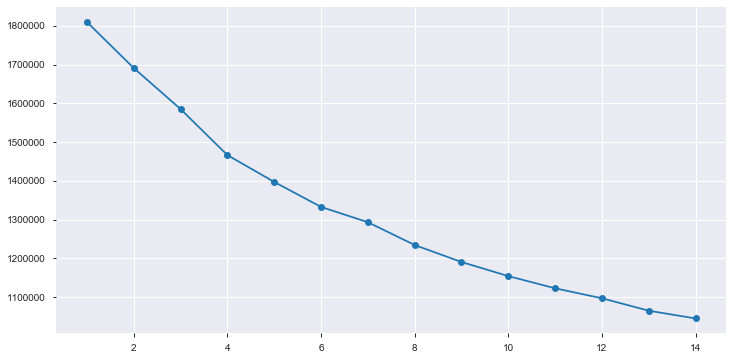

In [152]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [ ]:
# here we are not gettting a clear elbow shape but largest dip is from cluster 1 to cluster 2 so we go with 2 clusters

In [153]:
kmeans = KMeans(n_clusters=2, n_init = 15, random_state=2)

In [155]:
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [156]:
centroids=kmeans.cluster_centers_

In [157]:
centroid_df = pd.DataFrame(centroids, columns = list(X_scaled) )

In [158]:
centroid_df

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.052948,0.177989,0.157859,0.058598,0.185304,0.212572,0.168025,0.186389,0.187549,0.183311,...,0.000085,0.000034,0.000077,-0.000051,-0.000045,-0.000028,0.000022,0.000007,0.000046,0.000017
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,-3.384561,-1.338384,-3.053998,2.031912,1.798034,1.127170,-0.870807,-0.269076,-1.810719,-0.689658


In [159]:
## creating a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))

df_labels['labels'] = df_labels['labels'].astype('category')

In [160]:

df_labeled = X_scaled.join(df_labels)

In [161]:
df_labeled=df_labeled.join(Y)

In [162]:
df_labeled.head()

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,labels,shares
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.228941,-0.708369,-0.268895,-0.969886,0.671245,-0.975432,-1.810719,0.138920,0,593
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.228941,1.102174,1.367424,0.078642,-0.870807,-0.269076,0.837749,-0.689658,0,711
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.981798,-1.621797,-0.957871,-0.270867,-0.870807,-0.269076,0.837749,-0.689658,0,1500
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.174639,-0.862584,-0.268895,-0.620377,-0.870807,-0.269076,0.837749,-0.689658,0,1200
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.981798,0.307944,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056,0,505


In [163]:
clusters = df_labeled.groupby(['labels'])

df0=clusters.get_group(0)
df1=clusters.get_group(1)


In [164]:
final_df=pd.concat([df0,df1])
final_df.head()

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,labels,shares
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.228941,-0.708369,-0.268895,-0.969886,0.671245,-0.975432,-1.810719,0.138920,0,593
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.228941,1.102174,1.367424,0.078642,-0.870807,-0.269076,0.837749,-0.689658,0,711
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.981798,-1.621797,-0.957871,-0.270867,-0.870807,-0.269076,0.837749,-0.689658,0,1500
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.174639,-0.862584,-0.268895,-0.620377,-0.870807,-0.269076,0.837749,-0.689658,0,1200
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.981798,0.307944,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056,0,505


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.36962704118853273


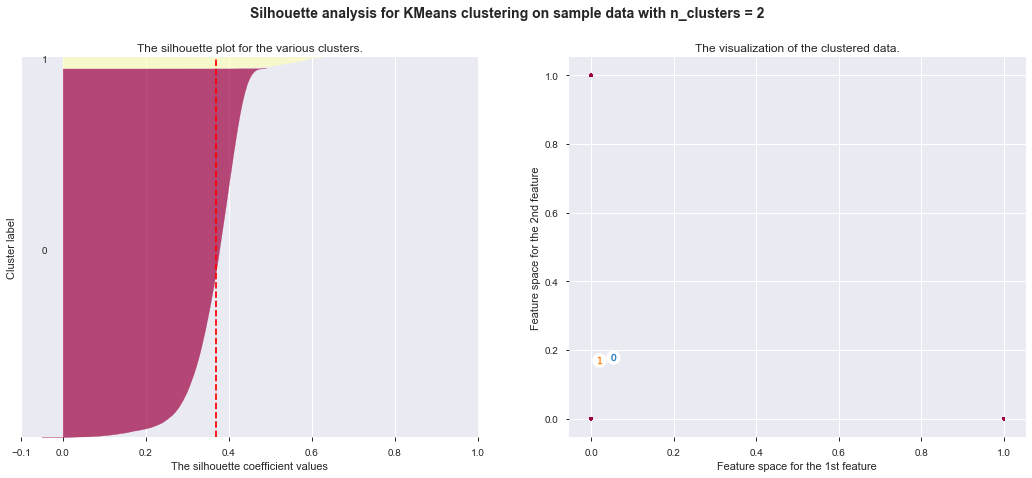

For n_clusters = 3 The average silhouette_score is : 0.08496140185853743


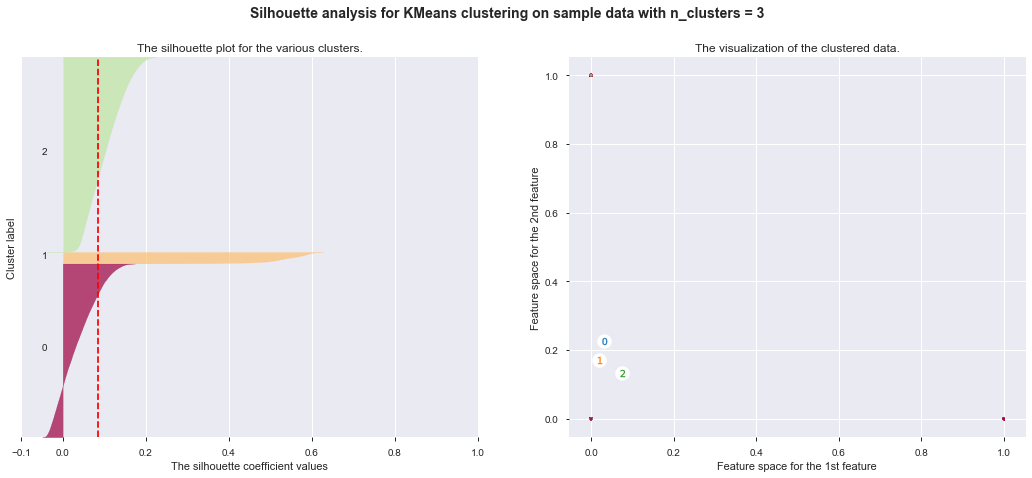

For n_clusters = 4 The average silhouette_score is : 0.08481012552639577


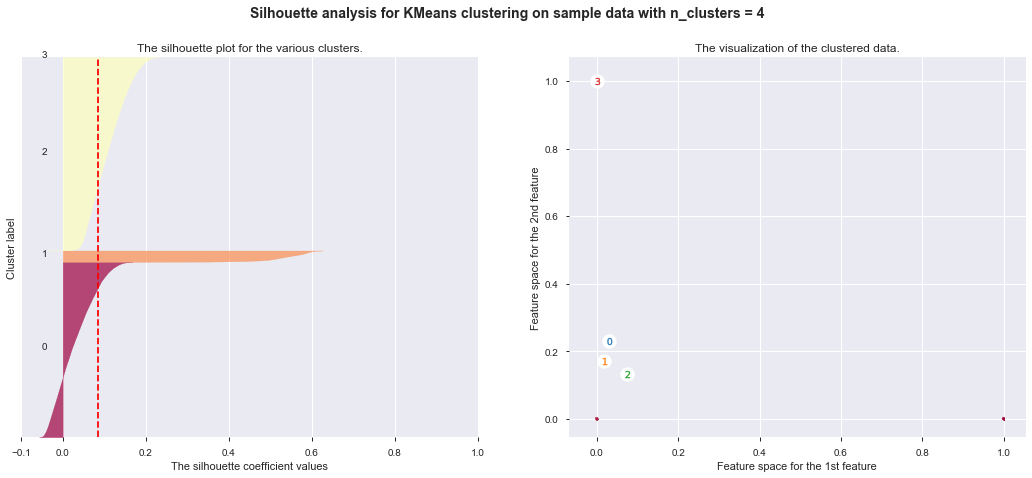

For n_clusters = 5 The average silhouette_score is : 0.06014029221103083


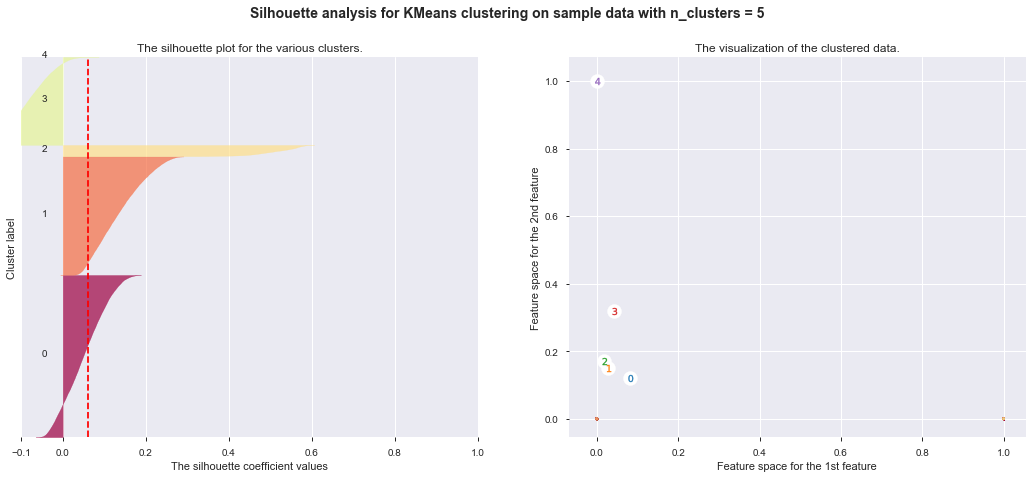

For n_clusters = 6 The average silhouette_score is : 0.0683033448433698


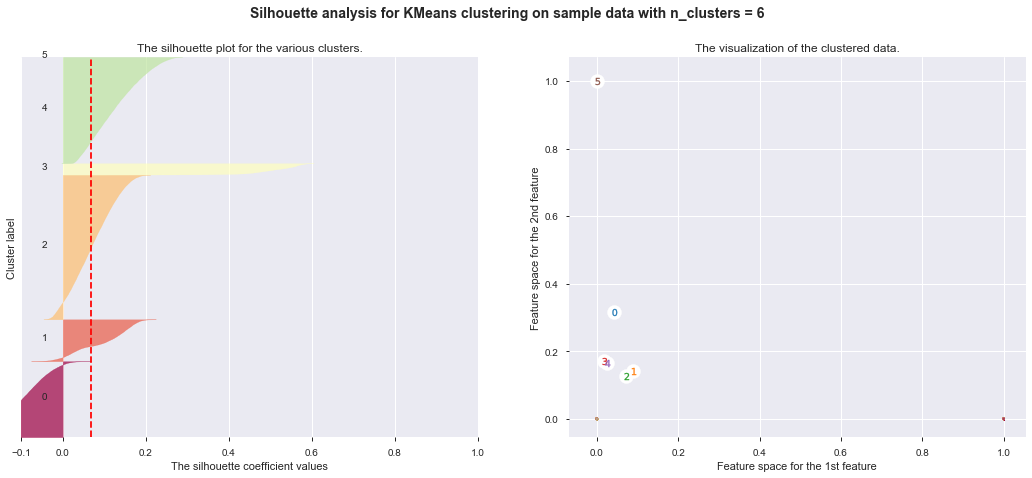

For n_clusters = 7 The average silhouette_score is : 0.07516300286547954


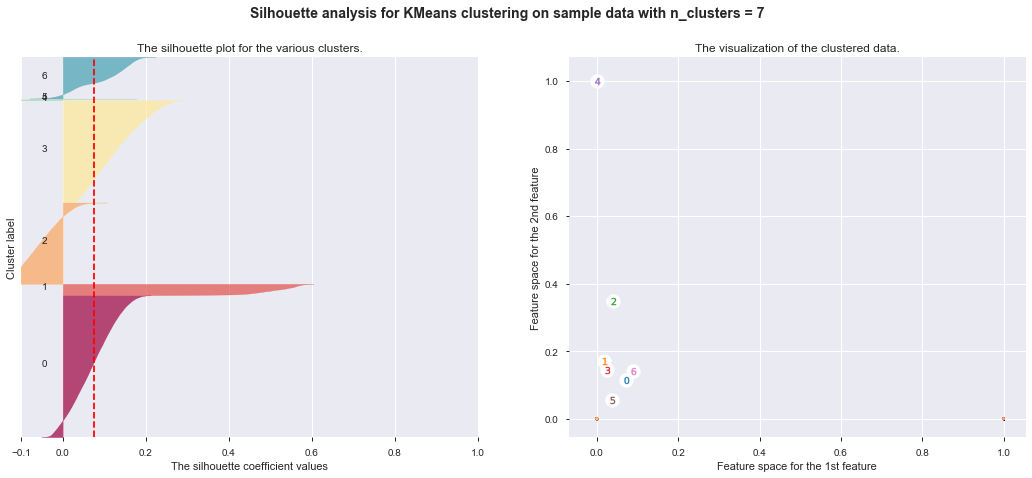

For n_clusters = 8 The average silhouette_score is : 0.06960537505379182


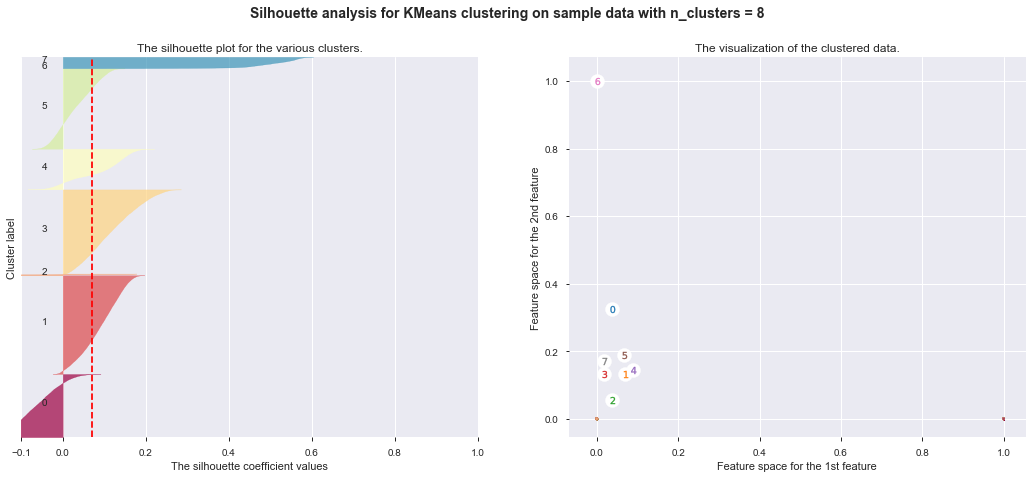

For n_clusters = 9 The average silhouette_score is : 0.07117654315980056


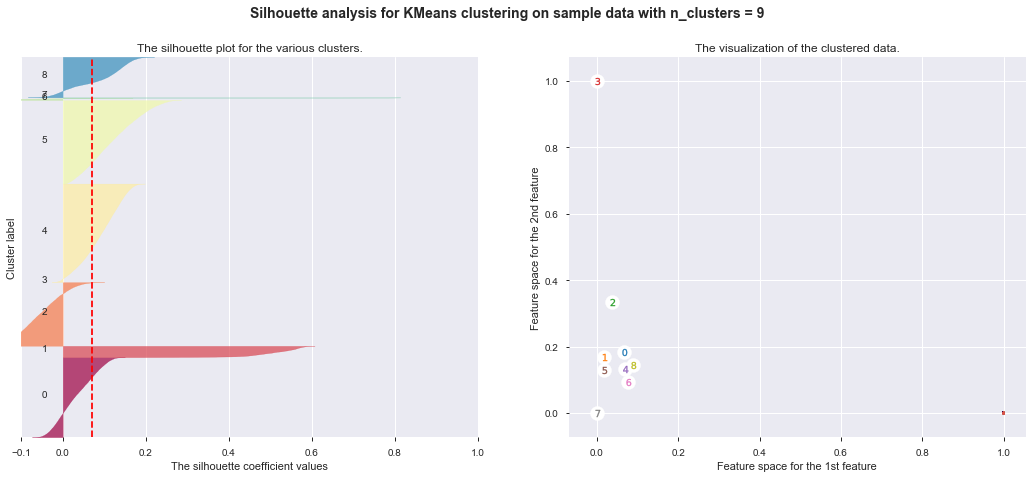

For n_clusters = 10 The average silhouette_score is : 0.07537775647127205


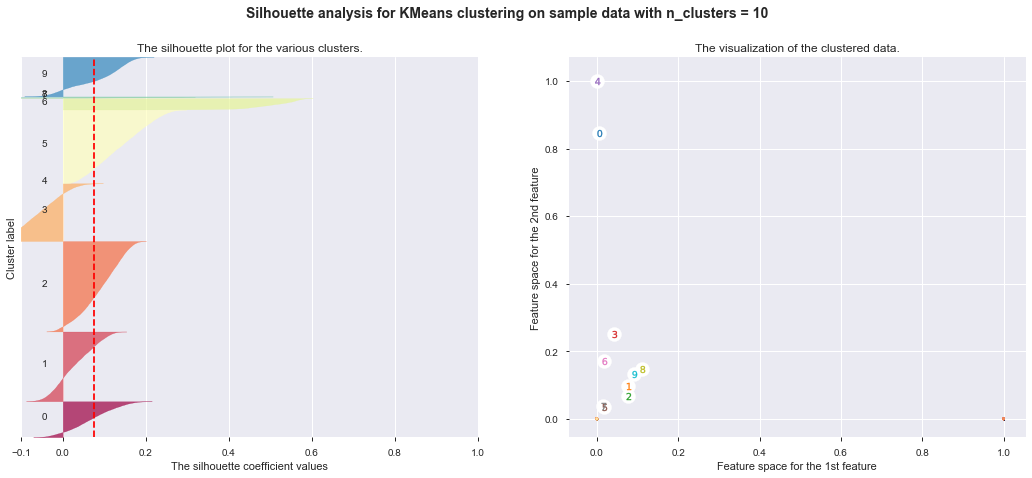

For n_clusters = 11 The average silhouette_score is : 0.08621636765071003


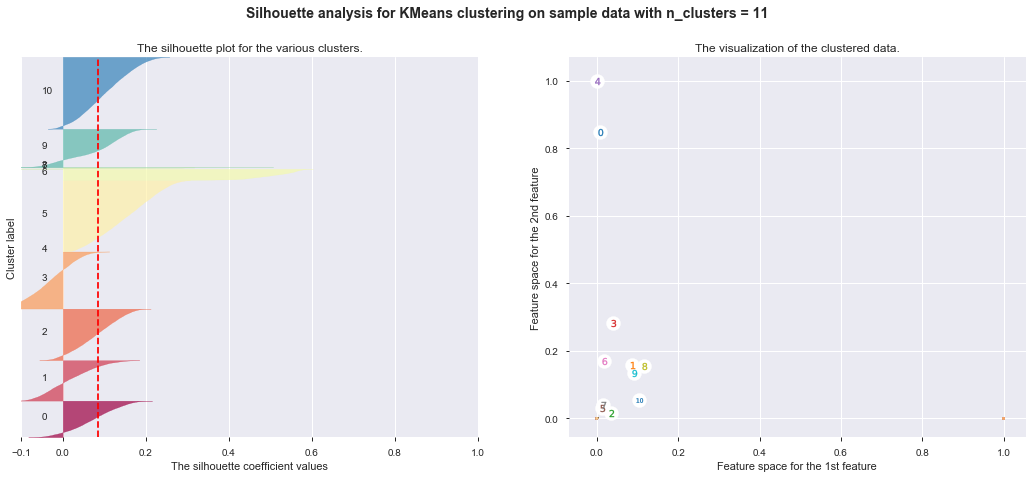

For n_clusters = 12 The average silhouette_score is : 0.08978339749681119


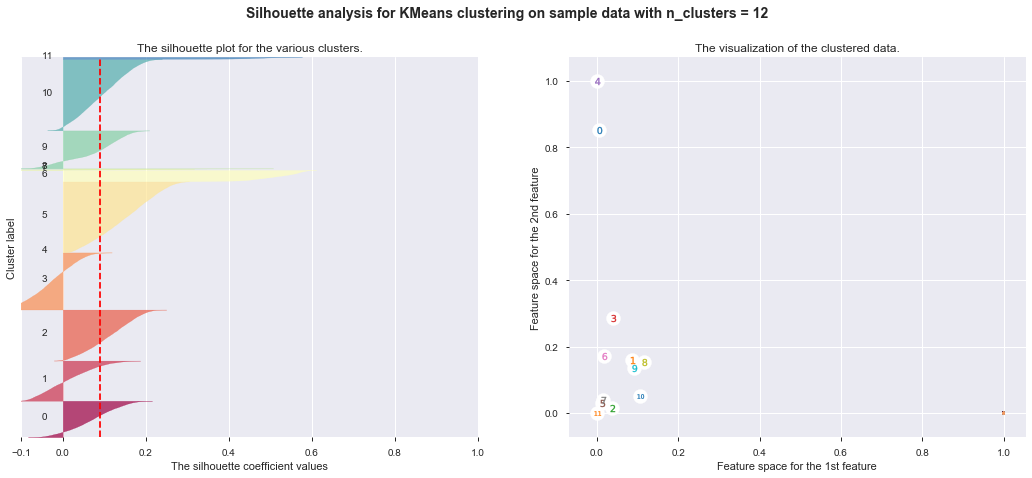

For n_clusters = 13 The average silhouette_score is : 0.09045610207953571


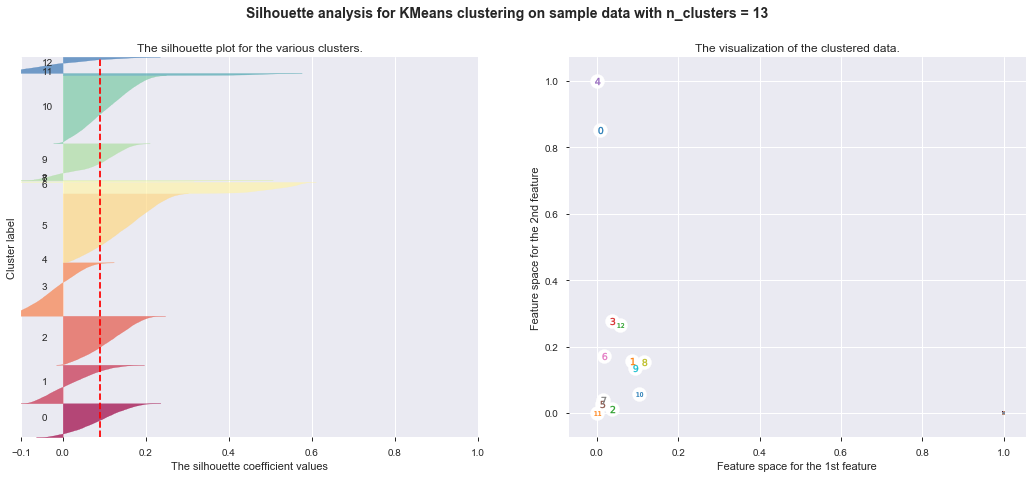

For n_clusters = 14 The average silhouette_score is : 0.0912270407138045


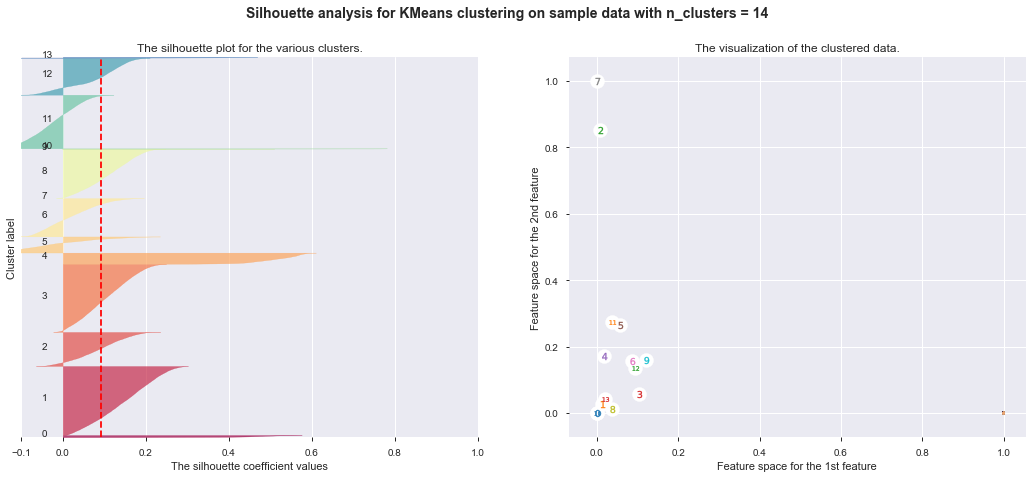

In [165]:
## from __future__ import print_function
%matplotlib inline


from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=X_scaled.values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [167]:
# The silhoutte score is max for 2 clusters so 2 classes are optimal for this dataset and significannt dip in silhoutte 
#score for  3 clusters so we can't make this prob as multiclass